### Load data
There are 6 folders: train, val, test, and mask to each of them

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
from tqdm.notebook import tqdm
from collections import defaultdict
from copy_paste import CopyPaste

import copy
import random

DATA_DIR = 'E:\\few_data\\few_data\\'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

def visualize(**images):
    n = len(images)
    for i, (name, image) in enumerate(images.items()):

        plt.figure(figsize=(50, 50))

        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [29]:
# Redefine dataset class
class Dataset(BaseDataset):
    CLASSES = ['coal','bound']

    def __init__(
            self,
            images_dir, #filenames
            masks_dir, #dataframe
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i])[:,:,1:3] / 255.0
        # mask = cv2.imread(self.masks_fps[i])[:,:,1:3] / 255.0
        # x y 1 + concatcat
        # mask2 =msak1-2
        #print(mask.shape)
        # extract certain classes from mask (e.g. coal)
        #masks = [(mask == v) for v in self.class_values]
        #mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids) #len filenames

### Visualize data

(512, 1320)


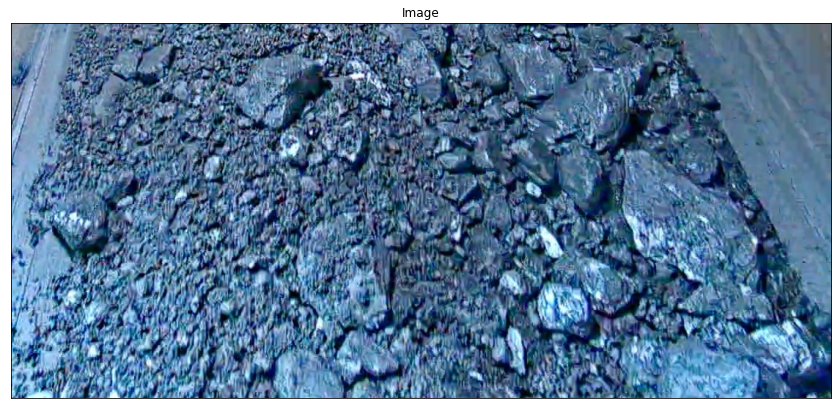

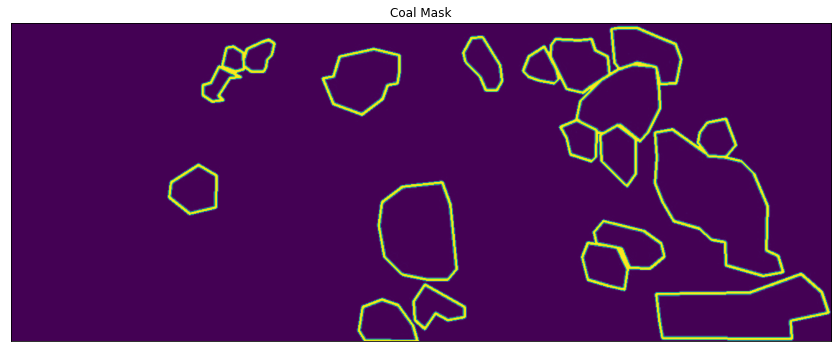

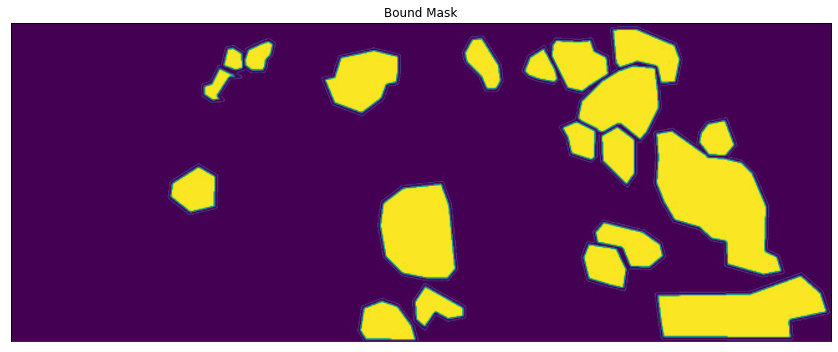

In [30]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['coal','bound'])

image, mask = dataset[0] # get some sample
print(mask[..., 0].squeeze().shape)
visualize(
    image=image,
    coal_mask=mask[..., 0].squeeze(),
    bound_mask=mask[..., 1].squeeze(),
)

### Augmentations

In [4]:
def get_training_augmentation():
    return albu.Compose([
        albu.RandomCrop(height=512, width=512,p=1.0),

        albu.OneOf(
            [
            albu.HorizontalFlip(p=1.0),
            albu.VerticalFlip(p=1.0),
            albu.RandomRotate90(p=1.0),
            ],p=0.9),
        #albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.2),
        albu.OneOf(
            [
                albu.RandomBrightness(p=1),
                albu.CLAHE(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.6,
        ),
        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
                albu.RandomBrightnessContrast(p=1.0),
            ],
            p=0.9,
        ),
        #CopyPaste(blend=True, sigma=1, pct_objects_paste=0.5, p=1),
        #albu.ElasticTransform(p=0.2, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
    ])

def get_validation_augmentation():
    return albu.Compose([
        albu.Resize(512, 512),
        #albu.RandomCrop(height=512, width=512,p=1.0),
    ])


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

### Visualize augmentations

c:\users\sergey\pycharmprojects\test\venv\lib\site-packages\albumentations\augmentations\transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
c:\users\sergey\pycharmprojects\test\venv\lib\site-packages\albumentations\augmentations\transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


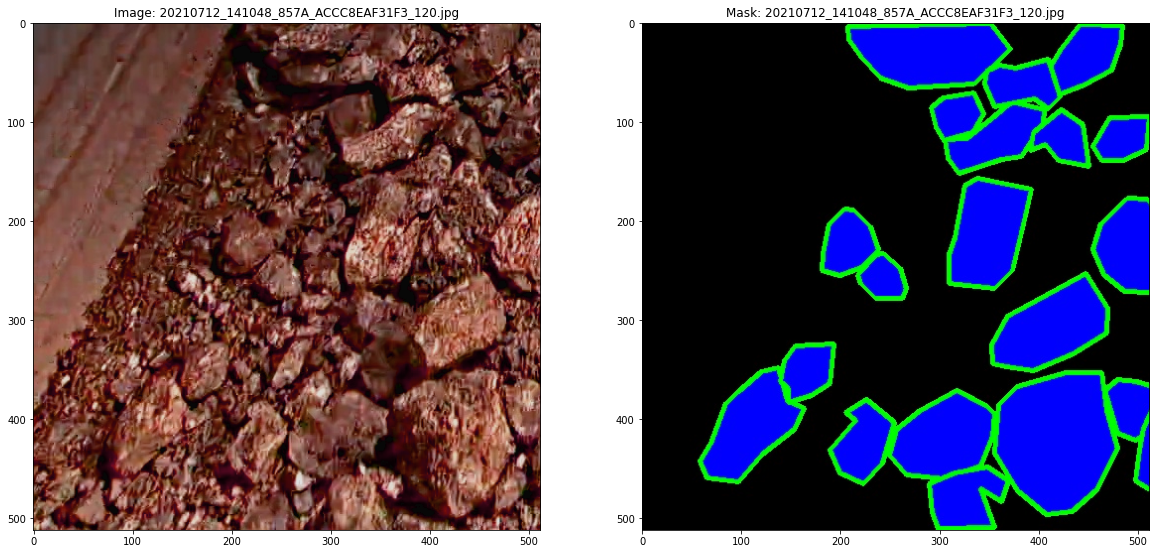

In [5]:
def show_examples(name, image, mask):
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")

def show(image_path, masks, transforms=None):
    image = cv2.imread(image_path)
    mask = cv2.imread(masks)

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(image_path.split('\\')[-1], image, mask)

show("E:\\few_data\\few_data\\train\\20210712_141048_857A_ACCC8EAF31F3_120.jpg",
     "E:\\few_data\\few_data\\trainannot\\20210712_141048_857A_ACCC8EAF31F3_120.jpg",
     transforms=get_training_augmentation())



### Initialize model

In [6]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['coal','bound']
ACTIVATION = 'softmax2d'
# if torch.cuda.is_available():
# else:
#DEVICE = 'cpu'
DEVICE = 'cuda'

aux_params=dict(
    pooling='avg',
    dropout=0.2,
    activation='softmax',
    classes=3,
)

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    #aux_params=aux_params
)
#preprocessing_fn = lambda x: x /255.0
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
print(preprocessing_fn)



functools.partial(<function preprocess_input at 0x0000026350DACB70>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


### Initialize dataset

In [7]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
test_dataloader = DataLoader(test_dataset)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)


In [8]:
from torch import nn

class OwnLoss(nn.Module):
    __name__ = "own"
    def __init__(self):
        super(OwnLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss('multilabel', from_logits=True)
        self.bce_loss = torch.nn.BCELoss()
    def forward(self,out,target):
        loss1 = self.dice_loss(out,target)
        loss2 = self.bce_loss(out,target)

        loss_extra = self.bce_loss(out[:,0:1]*target[:,1:2].to(DEVICE), torch.zeros_like(target[:,1:2], dtype=torch.float32, device=DEVICE))

        loss_sum = loss1 + loss2 + 10*loss_extra
        return loss_sum

In [9]:

from torchmetrics import IoU
#iou = IoU(3)
# setup model

loss = OwnLoss()
#loss=   torch.nn.NLLLoss(weight=torch.tensor([0.5,1.0,0.5]))
metrics = [
    #smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[1,2,3]),
    #smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,2,3]),
    #smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,3]),
    smp.utils.metrics.IoU(threshold=0.5),
    #smp.metrics.iou_score(*smp.metrics.get_stats(x, y, mode='multilabel', threshold=0.5,num_classes=3),class_weights=[0.5,1.0,1.0]),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [10]:
print(metrics[0])

IoU(
  (activation): Activation(
    (activation): Identity()
  )
)


In [11]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=torch.device(DEVICE),
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=torch.device(DEVICE),
    verbose=True,
)
train_epoch.metrics[0].__name__="IoU_Class0"
#train_epoch.metrics[1].__name__="IoU_Class1"
#train_epoch.metrics[2].__name__="IoU_Class2"
#train_epoch.loss.__name__="IoU_Clas2s0"


### Train model

In [12]:
def train_step(train_loader, model, optimizer, loss, metrics={}):
    pbar = tqdm(train_loader)
    log_data = defaultdict(list)
    for im, mask, edge, conn in pbar:
        optimizer.zero_grad()
        model.zero_grad()
        mask = torch.cat([mask, edge], dim=1)
        out1, out2 = model(im.to(DEVICE))
        #         print(out.max(), out.min(), mask.max(), mask.min())
        #         print(out.min(), out.max(), bin_out.max(), bin_out.min())
        l = loss(out1, mask.to(DEVICE))
        log_data['bce1'].append(l.item())
        d = dice_loss(out1, mask.to(DEVICE))
        log_data['dice1'].append(d.item())
        l+=d

        extra_l = loss(out1[:,0:1]*edge.to(DEVICE), torch.zeros_like(edge, dtype=torch.float32, device=DEVICE))
        log_data['extra_bce1'].append(extra_l.item())
        #         #extra_d = dice_loss(out*edge.to(DEVICE), torch.zeros_like(mask, dtype=torch.float32, device=DEVICE))
        #         #log_data['extra_dice'].append(extra_d.item())
        l=l+10*extra_l#+10*extra_d

        l2 = loss(out2, mask.to(DEVICE))
        log_data['bce2'].append(l2.item())
        d2 = dice_loss(out2, mask.to(DEVICE))
        log_data['dice2'].append(d2.item())
        l+=l2+d2

        extra_l2 = loss(out2[:,0:1]*edge.to(DEVICE), torch.zeros_like(edge, dtype=torch.float32, device=DEVICE))
        log_data['extra_bce2'].append(extra_l2.item())
        #         #extra_d = dice_loss(out*edge.to(DEVICE), torch.zeros_like(mask, dtype=torch.float32, device=DEVICE))
        #         #log_data['extra_dice'].append(extra_d.item())
        l=l+10*extra_l2#+10*extra_d

        l.backward()
        optimizer.step()

        #         for metric_name, metric in metrics.items():
        #             for j in range(mask.shape[1]):
        # #                 print(mask.shape, out.shape)
        #                 m = metric(out[:,j], mask[:,j].to(DEVICE, dtype=torch.long))
        #                 log_data[metric_name+'_'+str(j)].append(m.item())

        l_data = l.item()
        log_data['loss'].append(l_data)
        d = {k: v[-1] for k, v in log_data.items()}
        pbar.set_postfix(d)
    log_data = {key: np.mean(l) for key, l in log_data.items()}
    pbar.set_postfix(log_data)
    pbar.update(1)
    return log_data

In [13]:
max_score = 0
val_losses = []
train_losses = []

val_losses1 = []
train_losses1 = []

val_losses2 = []
train_losses2 = []
for i in range(0, 10):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_losses.append(train_logs['IoU_Class0'])
    val_losses.append(valid_logs['IoU_Class0'])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['IoU_Class0']:
        max_score = valid_logs['IoU_Class0']
        torch.save(model, './best_model3.pth')
        print('Model saved!')




Epoch: 0
valid: 100%|██████████| 4/4 [00:00<00:00, 11.77it/s, own - 3.113, IoU_Class0 - 0.09209]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:00<00:00, 13.60it/s, own - 4.688, IoU_Class0 - 0.07342]

Epoch: 2
valid: 100%|██████████| 4/4 [00:00<00:00, 13.28it/s, own - 5.15, IoU_Class0 - 0.07952] 

Epoch: 3
valid: 100%|██████████| 4/4 [00:00<00:00, 14.22it/s, own - 5.683, IoU_Class0 - 0.06008]

Epoch: 4
valid: 100%|██████████| 4/4 [00:00<00:00, 13.13it/s, own - 4.331, IoU_Class0 - 0.09466]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:00<00:00, 14.49it/s, own - 3.532, IoU_Class0 - 0.07969]

Epoch: 6
valid: 100%|██████████| 4/4 [00:00<00:00, 14.30it/s, own - 4.248, IoU_Class0 - 0.06872]

Epoch: 7
valid: 100%|██████████| 4/4 [00:00<00:00, 14.51it/s, own - 2.82, IoU_Class0 - 0.1109] 
Model saved!

Epoch: 8
valid: 100%|██████████| 4/4 [00:00<00:00, 14.90it/s, own - 2.666, IoU_Class0 - 0.1196] 
Model saved!

Epoch: 9
valid: 100%|██████████| 4/4 [00:00<00:00, 14.46it/s, own 

### Evaluate model

In [14]:
best_model = torch.load('./best_model3.pth')
best_model.eval()

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)
#logs = test_epoch.run(test_dataloader)


### Visualize result

In [21]:
path = "E:\\few_data\\few_data\\test\\"
image_path = 'vlcsnap-2022-01-26-cut.jpg'

best_model = torch.load('./best_model3.pth')
best_model.eval()

image = cv2.imread(path+image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig = image.copy().astype('float32')

trf = albu.Compose([albu.Lambda(image=preprocessing_fn)])
image = trf(image=image)['image']
image = cv2.resize(image,(512,512))
image = image.transpose(2, 0, 1).astype('float32')

x_tensor = torch.from_numpy(image).to('cuda').unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask1 = ((pr_mask.squeeze(0).cpu().numpy())*255).transpose(1, 2, 0)
print(pr_mask1.shape)
pr_mask1 = cv2.resize(pr_mask1,(1320,512))
b,g = cv2.split(pr_mask1)

cv2.imwrite(path+"mask_b"+image_path, np.where(b>160,0,255).astype(dtype=np.uint8))
cv2.imwrite(path+"mask_g"+image_path, np.where(g>100,255,0).astype(dtype=np.uint8))

test = pr_mask.squeeze(0).cpu().numpy()
test = test.transpose(1, 2,0)
#test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test = cv2.resize(test,(1320,512))
#test = 1.0 - test

#foreground = cv2.multiply(orig, test)

# cv2.imwrite(r"E:\few_data\few_data\test\predicted_res.jpg",foreground)

(512, 512, 2)


In [ ]:


'''
path = "E:\\few_data\\few_data\\test\\"
image_path = 'vlcsnap-2022-01-26-cut.jpg'

best_model = torch.load('./best_model3.pth')
best_model.eval()

image = cv2.imread(path+image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig = image.copy().astype('float32')

trf = albu.Compose([albu.Lambda(image=preprocessing_fn)])
image = trf(image=image)['image']
image = cv2.resize(image,(512,512))
image = image.transpose(2, 0, 1).astype('float32')

x_tensor = torch.from_numpy(image).to('cuda').unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask1 = ((pr_mask.squeeze(0).cpu().numpy())*255).transpose(1, 2, 0)
pr_mask1 = cv2.resize(pr_mask1,(1120,512))

cv2.imwrite(path+"mask_"+image_path, pr_mask1)

test = pr_mask.squeeze(0).cpu().numpy()
test = test.transpose(1, 2,0)
#test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test = cv2.resize(test,(1120,512))
#test = 1.0 - test

foreground = cv2.multiply(orig, test)

cv2.imwrite(r"E:\few_data\few_data\test\predicted_res.jpg",foreground)

'''